In [219]:
import numpy as np # v. 1.22.1
from matplotlib import pyplot as plt # v. 3.7.5
import os
import pandas as pd # v. 1.5.3
from scipy import stats
from itertools import combinations

import sys
# appending the directory of pca.py in the sys.path list
sys.path.append('../mchem_functions')
import PCA_functions as pcf

In [220]:
SUVA_dir = '../../Data/SUVA'
uvvis_dir = 'UV-vis'
uvvis_spectra_dir = uvvis_dir + '/spectra'
toc_dir = 'TOC'
outliers = ['MP-AM-PW-D-25-02-2025-TOC']
image_format = 'svg' #jpeg, png, svg...

In [221]:
try: os.chdir(SUVA_dir)
except FileNotFoundError: pass

suva_plots_dir = 'suva_plots'
if not os.path.exists(suva_plots_dir): os.mkdir(suva_plots_dir)

if not image_format.startswith('.'): image_format = '.' + image_format

In [222]:
def season(date:str,sep='-'):
    if sep in date:
        month = int(date.split(sep)[1])
    else:
        month = int(date)

    if month in [9,10,11]: return 'Aut'
    elif month == 1: return 'Win1'
    elif month == 2: return 'Win2'
    elif month in [3,4,5]: return 'Spr'
    elif month in [6,7,8]: return 'Sum'

def sample_info(name:str):
    name = name.split('-')
    site = name[1]
    sample_type = name[2]
    if sample_type == 'PW':
        replicate_letter = name[3]
        dd = name[4]
        mm = name[5]
        yyyy = name[6]
    elif sample_type == 'PL':
        replicate_letter = 'NA'
        dd = name[3]
        mm = name[4]
        yyyy = name[5]
    seas = season(mm)
    return site, sample_type, replicate_letter, dd, mm, yyyy, seas

def roman_to_integer(roman_no:str)->int:
    '''
    Convert a roman numeral to its corresponding integer value.
    '''
    roman_no = roman_no.lower()

    tot = roman_no.count('i') + roman_no.count('v') * 5 + roman_no.count('x') * 10 + roman_no.count('l') * 50 + roman_no.count('c') * 100 + roman_no.count('d') * 500 + roman_no.count('m') * 1000
    if 'iv' in roman_no: tot -= roman_no.count('iv') * 2
    if 'ix' in roman_no: tot -= roman_no.count('ix') * 2
    if 'xl' in roman_no: tot -= roman_no.count('xl') * 20
    if 'xc' in roman_no: tot -= roman_no.count('xc') * 20
    if 'cd' in roman_no: tot -= roman_no.count('cd') * 200
    if 'cm' in roman_no: tot -= roman_no.count('cm') * 200

    return tot

def suva(A,TOC,dil=1):
    return 100 * A * dil / TOC # 100 cm / M, returns L / (M mg C)

def sig_figs(x, precision): #from https://mattgosden.medium.com/rounding-to-significant-figures-in-python-2415661b94c3
    """
    Rounds a number to number of significant figures
    Parameters:
    - x - the number to be rounded
    - precision (integer) - the number of significant figures
    Returns:
    - float
    """

    precision = precision

    if type(x) == np.ndarray:
        x = x.astype(float)
        return np.round(x, -np.floor(np.log10(np.abs(np.max(x)))).astype(int) + (precision - 1))

    else:
        x = float(x)
        return np.round(x, -int(np.floor(np.log10(np.abs(x)))) + (precision - 1))



In [223]:
files = os.listdir(uvvis_spectra_dir)

sample_name_list = []
site_list = []
sample_type_list = []
replicate_letter_list = []
dd_list = []
mm_list = []
yyyy_list = []
dilution_factor_list = []
tech_replicate_list = []
season_list = []

for f in files:
    
    if not np.all([x in f for x in outliers]) or outliers in [[],['']]:
        spectrum_df = pd.read_csv(f'{uvvis_spectra_dir}/{f}',skiprows=1)
        if f == files[0]:
            wls = spectrum_df['Wavelength nm.'].to_numpy()
            intensities_array = spectrum_df['Abs.'].to_numpy()
        else:
            intensities_array = np.vstack((intensities_array,spectrum_df['Abs.'].to_numpy()))

        f = f.split('_')

        sample_name_list.append(f[0])
        site, sample_type, replicate_letter, dd, mm, yyyy, seas = sample_info(f[0])
        dilution_factor = int(f[1].replace('x',''))

        tech_replicate = roman_to_integer(f[2])

        site_list.append(site)
        sample_type_list.append(sample_type)
        replicate_letter_list.append(replicate_letter)
        dd_list.append(dd)
        mm_list.append(mm)
        yyyy_list.append(yyyy)
        dilution_factor_list.append(dilution_factor)
        tech_replicate_list.append(tech_replicate)
        season_list.append(seas)

In [224]:
spectra_df = pd.DataFrame(intensities_array,columns=wls.astype(str))

In [225]:

samples_info = {
    'sample_name': np.array(sample_name_list),
    'site': np.array(site_list),
    'sample_type': np.array(sample_type_list),
    'replicate_letter': np.array(replicate_letter_list),
    'day': np.array(dd_list),
    'month': np.array(mm_list),
    'year': np.array(yyyy_list),
    'season': np.array(season_list),
    'dilution_factor': np.array(dilution_factor_list),
    'tech_replicate': np.array(tech_replicate_list),
}
info_df = pd.DataFrame(samples_info)
# info_df

In [226]:
df = pd.concat([info_df.reset_index(drop=True),spectra_df.reset_index(drop=True)], axis=1)
# df

In [227]:
def suva_error(A,A_error,TOC,TOC_error,dil=1):
    # return suva_values * (np.sqrt( np.pow(A_error/A,2) + np.pow(TOC_error/TOC,2) * 100 * dil))
    factor = dil * 100
    return np.sqrt(  np.pow( (factor/TOC) * A_error,2) + np.pow( (factor*A / np.pow(TOC,2)) * TOC_error,2) )

In [228]:
chosen_wl = 254.0 #if integer, it must have .0
avg_atwl = []
std_atwl = []
dil_list = []
sample_name_list_unique = np.unique(sample_name_list)

toc_files = os.listdir(toc_dir)
toc_list = []
tn_list = []

for name in sample_name_list_unique:
    
    sel = df[df['sample_name']==name]
    avg_atwl.append(np.mean(sel[str(chosen_wl)]))
    # std_atwl.append(round(np.std(sel[str(chosen_wl)]),4))
    std_atwl.append(np.std(sel[str(chosen_wl)]))
    dil_list.append(np.unique(sel['dilution_factor'])[0])

    for f in toc_files:
        f_df = pd.read_csv(f'{toc_dir}/{f}',sep='\t',skiprows=10)[['Sample ID','Result(NPOC)','Result(TN)']]

        if len(f_df[f_df['Sample ID']==name]['Result(NPOC)'].to_list()) > 0:
            toc_list.append(f_df[f_df['Sample ID']==name]['Result(NPOC)'].to_list()[0])
                
        if len(f_df[f_df['Sample ID']==name]['Result(TN)'].to_list()) > 0:
            tn_list.append(f_df[f_df['Sample ID']==name]['Result(TN)'].to_list()[0])

if int(chosen_wl) == chosen_wl: chosen_wl = int(chosen_wl)

In [229]:
avg_atwl = np.array(avg_atwl)
std_atwl = np.array(std_atwl)
dil_arr = np.array(dil_list)
toc_arr = np.array(toc_list)
suva_values = suva(avg_atwl,toc_arr,dil=dil_arr)
TOC_error = 0.00005
TOC_error_arr = np.ones(len(sample_name_list_unique)) * TOC_error
std_suva = suva_error(avg_atwl,std_atwl,toc_arr,TOC_error,dil=dil_arr)
TN_error = 0.000005
tn_arr = np.array(tn_list)

A_atwl_df = pd.DataFrame({
    'sample_name': sample_name_list_unique,
    'dilution_factor': dil_list,
    f'avg_A_{chosen_wl}': sig_figs(avg_atwl,3),
    f'std_A_{chosen_wl}': sig_figs(std_atwl,1),
    'TOC_(mg/L)': toc_list,
    f'SUVA_{chosen_wl}_(L/M_mg_C)': sig_figs(suva_values,3),
    f'std_SUVA_{chosen_wl}_(L/M_mg_C)': sig_figs(std_suva,1),
    'TN_(mg/L)': tn_list,
})
# A_atwl_df

In [230]:
A_atwl_df.to_csv(f'{uvvis_dir}/SUVA_{chosen_wl}_data.csv',index=False)
# A_atwl_df

In [231]:
avg_site_list = []
avg_sample_type_list = []
avg_replicate_letter_list = []
avg_dd_list = []
avg_mm_list = []
avg_yyyy_list = []
avg_season_list = []

for name in A_atwl_df['sample_name']:
    avg_site, avg_sample_type, avg_replicate_letter, avg_dd, avg_mm, avg_yyyy, avg_seas = sample_info(name)

    avg_site_list.append(avg_site)
    avg_sample_type_list.append(avg_sample_type)
    avg_replicate_letter_list.append(avg_replicate_letter)
    avg_dd_list.append(avg_dd)
    avg_mm_list.append(avg_mm)
    avg_yyyy_list.append(avg_yyyy)
    avg_season_list.append(avg_seas)

avg_samples_info = {
    'sample_name': A_atwl_df['sample_name'].to_numpy(),
    'site': np.array(avg_site_list),
    'sample_type': np.array(avg_sample_type_list),
    'replicate_letter': np.array(avg_replicate_letter_list),
    'day': np.array(avg_dd_list),
    'month': np.array(avg_mm_list),
    'year': np.array(avg_yyyy_list),
    'season': np.array(avg_season_list),
}

In [232]:
for site in np.unique(samples_info['site']):
    # samples_info = samples_info[site]
    # avg_samples_info = avg_samples_info[site]

    variable = 'SUVA_254_(L/M_mg_C)' #'avg_A_254', 'std_A_254', 'TOC_(mg/L)', 'SUVA_254_(L/M_mg_C)', 'std_SUVA_254_(L/M_mg_C)'
    filter_var = 'season' # 'sample_name', 'site', 'sample_type', 'replicate_letter', 'day', 'month', 'year', 'season'

    filt_list = []
    std_list = []

    for x in np.unique(samples_info[filter_var]):
        filt_list.append(A_atwl_df.loc[np.where((avg_samples_info[filter_var]==x)&(avg_samples_info['site']==site))][variable].to_numpy())

        if f'std_{variable}' in A_atwl_df.columns:
            std_list.append(A_atwl_df.loc[np.where((avg_samples_info[filter_var]==x)&(avg_samples_info['site']==site))][f'std_{variable}'].to_numpy())

# filt_list,std_list

In [233]:
variable_longname = {
    'SUVA_254_(L/M_mg_C)': ['SUVA$_{254}$','[L M$^{-1}$ (mg C)$^{-1}$]'],
    'TOC_(mg/L)': ['TOC','[mg L$^{-1}$]'],
    'TN_(mg/L)': ['Total N','[mg L$^{-1}$]'],
}
site_longname = {
    'AM': 'Auchencorth Moss',
    'HM': 'Hare Moss'
}

m_shape = {
    'AM': 's',
    'HM': 'o',
}

seasonal_colours = {
    'Aut': '#BF5700', # burnt orange
    'Win1': '#4B61D1', # Savoy blue
    'Win2': '#4E2A84', # northwestern purple
    'Spr': '#E0B0FF', # mauve
    'Sum': '#50C878', # emerald green
}

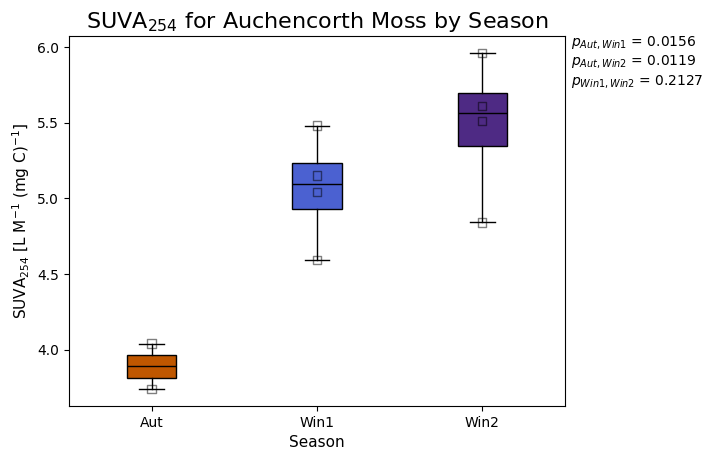

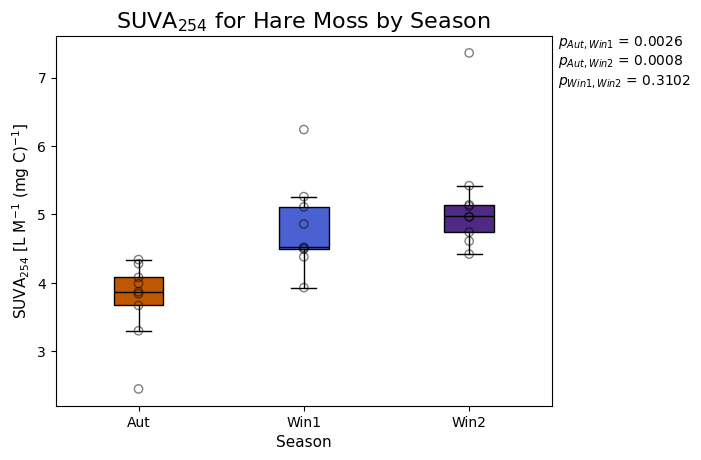

In [234]:
variable = 'SUVA_254_(L/M_mg_C)' #'avg_A_254', 'std_A_254', 'TOC_(mg/L)', 'SUVA_254_(L/M_mg_C)', 'std_SUVA_254_(L/M_mg_C)', 'TN_(mg/L)'

for site in np.unique(samples_info['site']):
    # samples_info = samples_info[site]
    # avg_samples_info = avg_samples_info[site]

    A_atwl_df_sitefilt = A_atwl_df.loc[np.where(avg_samples_info['site']==site)]

    fig_A_box, ax_A_box = plt.subplots()

    filter_var = 'season' # 'sample_name', 'site', 'sample_type', 'replicate_letter', 'day', 'month', 'year', 'season'

    filt_list = []
    std_list = []

    for x in np.unique(samples_info[filter_var]):
        filt_list.append(A_atwl_df.loc[np.where((avg_samples_info[filter_var]==x)&(avg_samples_info['site']==site))][variable].to_numpy())

    bplot = ax_A_box.boxplot(filt_list,tick_labels=np.unique(samples_info[filter_var][np.where(avg_samples_info['site']==site)]),
                     medianprops=dict(color='k',ls='-'),showfliers=False,patch_artist=True)
    for patch, colour in zip(bplot['boxes'], [seasonal_colours[k] for k in seasonal_colours]):
        patch.set_facecolor(colour)

    p_dict = {}
    uniq_var = np.unique(samples_info[filter_var])
    for comb in list(combinations(range(len(filt_list)),2)):
        p_dict[f'{uniq_var[comb[0]]},{uniq_var[comb[1]]}'] = stats.f_oneway(*[filt_list[comb[0]],filt_list[comb[1]]])[1]

    p_rounding = 4
    p_str = '\n'.join([f'$p_{{{key}}}$ = {np.round(p_dict[key],p_rounding)}' for key in p_dict])
    ax_A_box.text(.91,.885,p_str,ha='left',va='top',transform=plt.gcf().transFigure)
    
    for i in range(len(filt_list)):
        ax_A_box.scatter([i+1]*len(filt_list[i]),filt_list[i],zorder=2,facecolors='none',edgecolors='k',alpha=0.5,marker=m_shape[site])

    title = f'{variable_longname[variable][0]} for {site_longname[site]} by Season'
    ax_A_box.set_title(title,fontsize=16)

    ax_A_box.set_xlabel(filter_var.capitalize(),fontsize=11)
    ax_A_box.set_ylabel(f'{variable_longname[variable][0]} {variable_longname[variable][1]}',fontsize=11)

    fig_A_box.savefig(f'suva_plots/{title.lower().replace(' ','_').replace('$','').replace('{','').replace('}','')}.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')


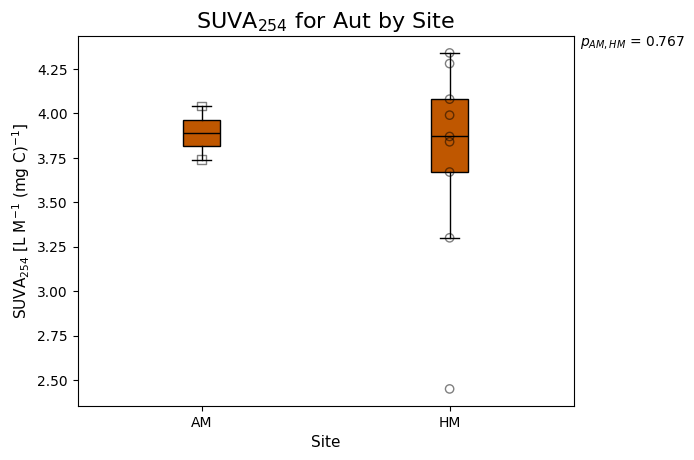

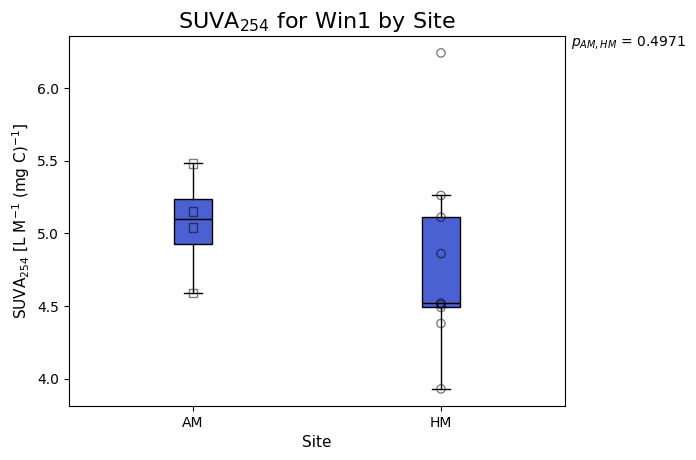

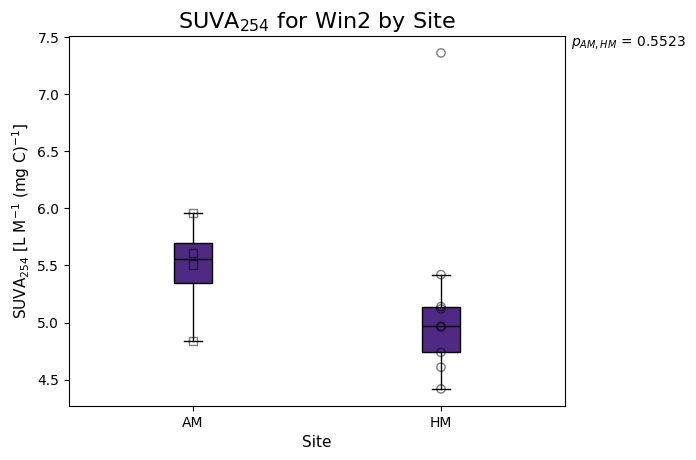

In [235]:
for season in np.unique(samples_info['season']):
    # samples_info = samples_info[season]
    # avg_samples_info = avg_samples_info[season]

    A_atwl_df_seasonfilt = A_atwl_df.loc[np.where(avg_samples_info['season']==season)]

    fig_A_box, ax_A_box = plt.subplots()

    filter_var = 'site' # 'sample_name', 'season', 'sample_type', 'replicate_letter', 'day', 'month', 'year', 'site'

    filt_list = []
    std_list = []

    for x in np.unique(samples_info[filter_var]):
        filt_list.append(A_atwl_df.loc[np.where((avg_samples_info[filter_var]==x)&(avg_samples_info['season']==season))][variable].to_numpy())

        # if f'std_{variable}' in A_atwl_df.columns:
        #     std_list.append(std_list.append(A_atwl_df.loc[np.where(avg_samples_info[filter_var]==x)][f'std_{variable}'].to_numpy()))

    bplot = ax_A_box.boxplot(filt_list,tick_labels=np.unique(samples_info[filter_var][np.where(avg_samples_info['season']==season)]),
                     medianprops=dict(color='k',ls='-'),showfliers=False,patch_artist=True)
    for patch in bplot['boxes']:
        patch.set_facecolor(seasonal_colours[season])

    p_dict = {}
    uniq_var = np.unique(samples_info[filter_var])
    for comb in list(combinations(range(len(filt_list)),2)):
        p_dict[f'{uniq_var[comb[0]]},{uniq_var[comb[1]]}'] = stats.f_oneway(*[filt_list[comb[0]],filt_list[comb[1]]])[1]

    p_rounding = 4
    p_str = '\n'.join([f'$p_{{{key}}}$ = {np.round(p_dict[key],p_rounding)}' for key in p_dict])
    ax_A_box.text(.91,.885,p_str,ha='left',va='top',transform=plt.gcf().transFigure)
    
    for i in range(len(filt_list)):
        ax_A_box.scatter([i+1]*len(filt_list[i]),filt_list[i],zorder=2,facecolors='none', edgecolors='k',alpha=0.5,marker=m_shape[list(m_shape.keys())[i]])

    title = f'{variable_longname[variable][0]} for {season} by Site'
    ax_A_box.set_title(title,fontsize=16)

    ax_A_box.set_xlabel(filter_var.capitalize(),fontsize=11)
    ax_A_box.set_ylabel(f'{variable_longname[variable][0]} {variable_longname[variable][1]}',fontsize=11)

    fig_A_box.savefig(f'suva_plots/{title.lower().replace(' ','_').replace('$','').replace('{','').replace('}','')}.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')


# PCA

In [236]:
chosen_PCs = [1,2]
scores_values, variance_ratio, PCs, loadings = pcf.get_pca_data(intensities_array,method='SNV',no_of_components=5)

In [237]:
len([x for x in intensities_array])

109

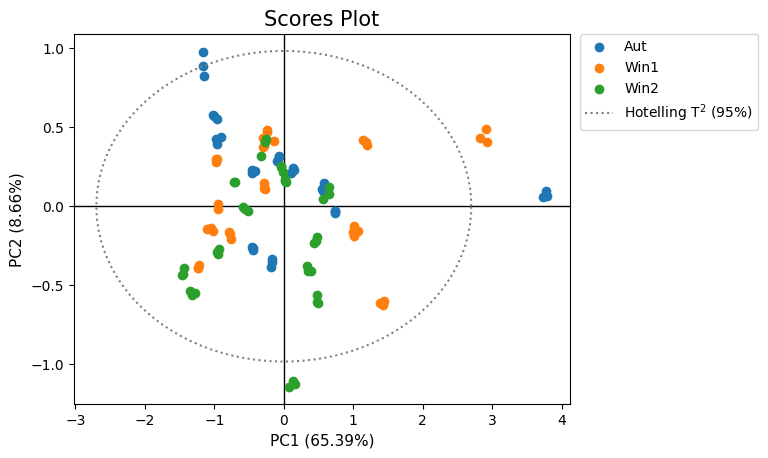

In [238]:
fig_scores, ax_scores = plt.subplots()

filter_var = 'season'

for x in np.unique(samples_info[filter_var]):
    pcf.scores_plot(scores_values[np.where(samples_info[filter_var]==x)],chosen_PCs,ax=ax_scores,lines=False,variance_ratio=variance_ratio,label=x,titlesize=15)

pcf.Hotelling(scores_values,chosen_PCs,ax_scores)

ax_scores.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

fig_scores.savefig(f'{suva_plots_dir}/suva_{chosen_wl}_pca_scores_pc{chosen_PCs[0]}&{chosen_PCs[1]}_by_{filter_var}{image_format}')

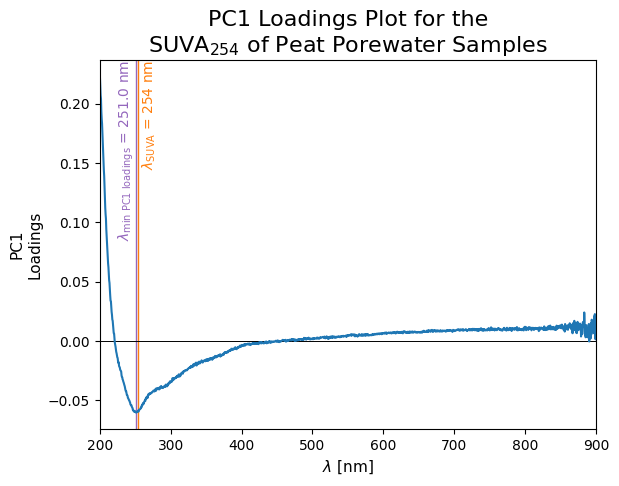

In [239]:
loadings_PCs = [1] #chosen_PCs [1]
fig_loadings = plt.figure()
ax_loadings = fig_loadings.subplots(len(loadings_PCs),sharex=True)

pcf.loadings_plot(wls,loadings.T,loadings_PCs,xlabel='$\\lambda$ [nm]',ax=ax_loadings,title='PC1 Loadings Plot for the\nSUVA$_{254}$ of Peat Porewater Samples')

fig_loadings.savefig(f'{suva_plots_dir}/suva_{chosen_wl}_pca_loadings{image_format}', dpi = 600, facecolor = '#fff', bbox_inches='tight')

if len(loadings_PCs) == 1:

    ax_loadings.axvline(chosen_wl,c='tab:orange',linewidth=1,zorder=-1)

    min_wl = wls[np.where(loadings[0]==np.min(loadings[0]))][0]
    ax_loadings.axvline(min_wl,c='tab:purple',linewidth=1,zorder=-1)

    max_ylim = np.max(ax_loadings.get_ylim())
    x_range = np.max(ax_loadings.get_xlim()) - np.min(ax_loadings.get_xlim())

    if chosen_wl > min_wl:
        ax_loadings.text(chosen_wl+.005*x_range,max_ylim,f'$\\lambda_{{\\mathrm{{SUVA}}}}$ = {chosen_wl} nm',c='tab:orange',ha='left',va='top',rotation=90)
        ax_loadings.text(min_wl+.0005*x_range,max_ylim,f'$\\lambda_{{\\mathrm{{min\\ PC{loadings_PCs[0]}\\ loadings}}}}$ = {min_wl} nm',c='tab:purple',ha='right',va='top',rotation=90)
    elif chosen_wl == min_wl:
        ax_loadings.text(chosen_wl+.005*x_range,max_ylim,f'$\\lambda_{{\\mathrm{{SUVA}}}}$ = $\\lambda_{{\\mathrm{{min PC[{loadings_PCs[0]}] loadings}}}}$ = {chosen_wl} nm',c='k',ha='right',va='top',rotation=90)
    else:
        ax_loadings.text(chosen_wl+.005*x_range,max_ylim,f'$\\lambda_{{\\mathrm{{SUVA}}}}$ = {chosen_wl} nm',c='tab:orange',ha='right',va='top',rotation=90)
        ax_loadings.text(min_wl+.0005*x_range,max_ylim,f'$\\lambda_{{\\mathrm{{min PC{loadings_PCs[0]} loadings}}}}$ = {min_wl} nm',c='tab:purple',ha='left',va='top',rotation=90)

else:
    for i in range(len(loadings_PCs)):
            
            ax_loadings[i].axvline(chosen_wl,c='tab:orange',linewidth=1,zorder=-1)

            min_wl = wls[np.where(loadings[loadings_PCs[i]-1]==np.min(loadings[loadings_PCs[i]-1]))][0]
            ax_loadings[i].axvline(min_wl,c='tab:purple',linewidth=1,zorder=-1)

            max_ylim = np.max(ax_loadings[i].get_ylim())
            x_range = np.max(ax_loadings[i].get_xlim()) - np.min(ax_loadings[i].get_xlim())

            if chosen_wl > min_wl:
                ax_loadings[i].text(chosen_wl+.005*x_range,max_ylim,f'$\\lambda_{{\\mathrm{{SUVA}}}}$ = {chosen_wl} nm',c='tab:orange',ha='left',va='top',rotation=90)
                ax_loadings[i].text(min_wl+.0005*x_range,max_ylim,f'$\\lambda_{{\\mathrm{{min PC{loadings_PCs[i]} loadings}}}}$ = {min_wl} nm',c='tab:purple',ha='right',va='top',rotation=90)
            elif chosen_wl == min_wl:
                ax_loadings[i].text(chosen_wl+.005*x_range,max_ylim,f'$\\lambda_{{\\mathrm{{SUVA}}}}$ = $\\lambda_{{\\mathrm{{min PC[{loadings_PCs[i]}] loadings}}}}$ = {chosen_wl} nm',c='k',ha='right',va='top',rotation=90)
            else:
                ax_loadings[i].text(chosen_wl+.0005*x_range,max_ylim,f'$\\lambda_{{\\mathrm{{SUVA}}}}$ = {chosen_wl} nm',c='tab:orange',ha='right',va='top',rotation=90)
                ax_loadings[i].text(min_wl+.005*x_range,max_ylim,f'$\\lambda_{{\\mathrm{{min PC{loadings_PCs[i]} loadings}}}}$ = {min_wl} nm',c='tab:purple',ha='left',va='top',rotation=90)

In [240]:
# saddle
x = loadings[0,:]
dx = x[1]-x[0]
y = x**2 + 1
dydx = np.gradient(y, dx)
wl_int = [250,300]
idx = np.where((wls>np.min(wl_int))&(wls<np.max(wl_int)))
wls[idx][np.where(np.abs(dydx[idx])==np.min(np.abs(dydx[idx])))]

array([283.5])